# Multi-armed bandit

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

sns.set_style("whitegrid")

In [3]:
class UniformMultiArmedBandit:

    class Arm:

        def __init__(self, cost, distribution):
            self.cost = cost
            self.distribution = distribution

        def trigger(self):
            return self.distribution.rvs(1)[0] - self.cost

    def __init__(self, n_arms, costs = None, distributions = None):

        if not (distributions is None):
            assert len(distributions) == n_arms, "Distributions size should be equal to n_arms"
        else: 
            a_list = np.random.randint(1, 5, n_arms)
            b_list = np.random.randint(6, 10, n_arms)
            distributions = [stats.randint(a, b) for a, b in zip(a_list, b_list)]
        
        if not (costs is None):
            assert len(costs) == n_arms, "Costs size should be equal to n_arms"
        else:
            costs = np.random.randint(3, 8, n_arms)

        self.n_arms = n_arms

        self.arms = []
        for i in range(n_arms):
            new_arm = self.Arm(costs[i], distributions[i])
            self.arms.append(new_arm)
        
    def trigger(self, idx):
        return self.arms[idx].trigger()

## Single Arm

In [4]:
cost = 3
distribution = stats.randint(1, 7)

bandit = UniformMultiArmedBandit(1, [cost], [distribution])

In [5]:
real_exp = distribution.mean() - cost
print(real_exp)

0.5


In [6]:
N = 1000
records = []
means = []

for i in range(N):
    records.append(bandit.trigger(0))
    means.append(np.mean(records))

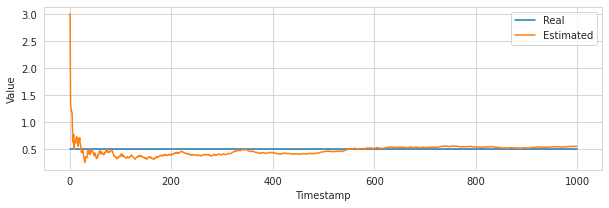

In [7]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_exp] * N)
plt.plot(np.arange(N), means)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real', 'Estimated'])
plt.show()

## Multiple Arms

In the beginning let us sample by one value for all the arms.

### Greedy

In [8]:
n_arms = 4
bandit = UniformMultiArmedBandit(n_arms)

In [9]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [10]:
rewards

[[-1], [-1], [-3], [-4]]

In [11]:
def greedy_policy(rewards):
    means = []
    # mean for each action
    for rew_list in rewards:
        means.append(np.mean(rew_list))
    
    return np.argmax(means)

In [12]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 1000

for i in range(N):
    # choosing an action
    action = greedy_policy(rewards)

    # recording the results
    estimated_mean_policy.append(np.mean(rewards[action]))
    rewards[action].append(bandit.trigger(action))
    real_mean_policy.append(actual_means[action])

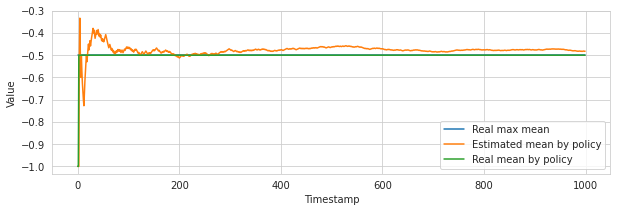

In [13]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N)
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

### $\epsilon$-greedy

In [14]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [15]:
def epsilon_greedy_policy(rewards, n_arms, epsilon):
    means = []
    # mean for each action
    for rew_list in rewards:
        means.append(np.mean(rew_list))
    main_action = np.argmax(means)
    
    probas = [epsilon / n_arms] * n_arms
    probas[main_action] += (1 - epsilon) 
    return np.array(probas)

In [16]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 1000

for i in range(N):
    # choosing an action
    action_probas = epsilon_greedy_policy(rewards, n_arms, epsilon = 0.1)
    action = np.random.choice(n_arms, size = 1, p = action_probas)[0]

    # recording the results
    estimated_mean_policy.append(np.mean(rewards[action]))
    rewards[action].append(bandit.trigger(action))
    real_mean_policy.append((actual_means * action_probas).sum())

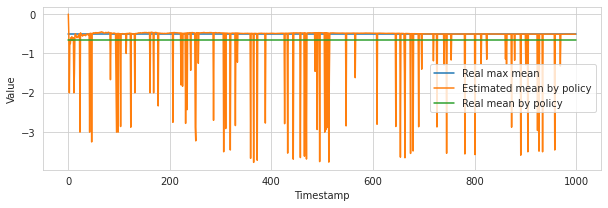

In [17]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N)
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

Decrease an epsilon.

In [18]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [19]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 100

for i in range(N):
    # choosing an action
    action_probas = epsilon_greedy_policy(rewards, n_arms, epsilon = 1/(i+1))
    action = np.random.choice(n_arms, size = 1, p = action_probas)[0]

    # recording the results
    estimated_mean_policy.append(np.mean(rewards[action]))
    rewards[action].append(bandit.trigger(action))
    real_mean_policy.append((actual_means * action_probas).sum())

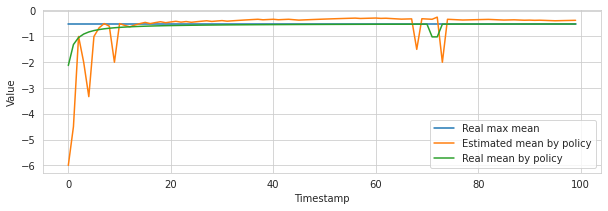

In [20]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N)
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

### SoftMax

In [21]:
from scipy.special import softmax

In [22]:
def softmax_policy(rewards):
    means = []
    # mean for each action
    for rew_list in rewards:
        means.append(np.mean(rew_list))
     
    return softmax(means)

In [23]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [24]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 100

for i in range(N):
    # choosing an action
    action_probas = softmax_policy(rewards)
    action = np.random.choice(n_arms, size = 1, p = action_probas)[0]

    # recording the results
    estimated_mean_policy.append(np.mean(rewards[action]))
    rewards[action].append(bandit.trigger(action))
    real_mean_policy.append((actual_means * action_probas).sum())

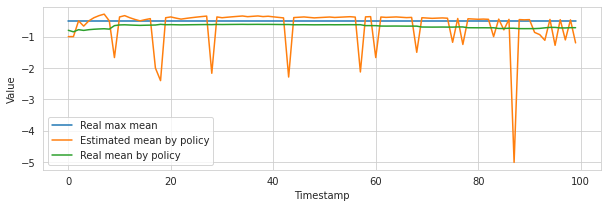

In [25]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N)
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

### Task

Implement Softmax with temperature policy and repeat the actions from above. Explain in your words (in text cell) why do we need to use softmax with temperature, not ordinary one. 

In [32]:
# based on https://www.youtube.com/watch?v=8ps_JEW42xs and https://www.youtube.com/watch?v=SFsc2P240rw

import math
import numpy as np
def softmax_temp_policy(rewards,t):
    means = []
    # mean for each action
    for rew_list in rewards:
        means.append(np.mean(rew_list))
    
    #exponintial transform
    means = np.array(means)
    exp = np.exp(means / t)
    sum = np.sum(exp, axis=0)
    output = exp / sum
    return output.flatten()

In [33]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [34]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 100

for i in range(N):
    # choosing an action
    action_probas = softmax_temp_policy(rewards=rewards, t=1)
    action = np.random.choice(n_arms, size = 1, p = action_probas)[0]

    # recording the results
    estimated_mean_policy.append(np.mean(rewards[action]))
    rewards[action].append(bandit.trigger(action))
    real_mean_policy.append((actual_means * action_probas).sum())

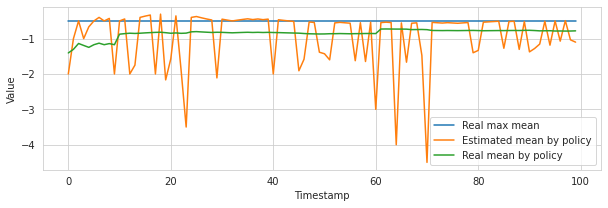

In [35]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N)
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

#Why Softmax with temprature?

Softmax tends to be overconfident and not necessarily good at perserving relativness.

One side effect of this exponentiation transformation is non perservance of the relativness of the change in input space relative to the output space. For example $exp(2)$ is $~7.3$ while $exp(4)$ is $~54.6$  

This problem was first mentioned in a paper called "Distlilling the Knowledge in a Neural Network" and introduced the idea of Temprature Scaling. 

In Temprature Scalling we devide our values with some constant T before performing the exponential transformation thus reducing the distance between elements in the ouptut space. Seemingly representing the input space better. 


# Bayesian

## Normal vs Continuous Uniform distributions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

sns.set_style("whitegrid")

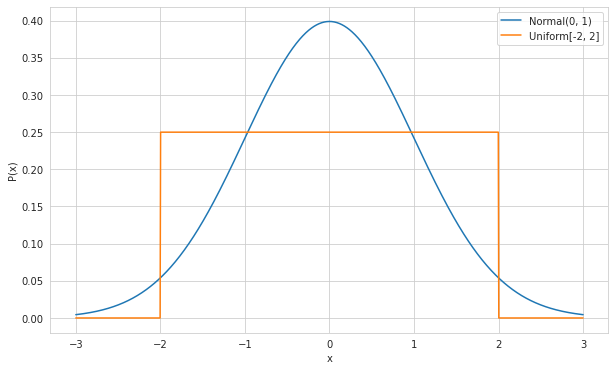

In [ ]:
# parameters
mu = 0
variance = 1
sigma = np.sqrt(variance)

a = -2
b = 4
# x
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# plotting
plt.figure(figsize = (10, 6))#, dpi = 300)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x, stats.uniform.pdf(x, a, b))
plt.xlabel("x")
plt.ylabel("P(x)")
plt.legend(['Normal(0, 1)', 'Uniform[-2, 2]'])
plt.show()

### Uniform case

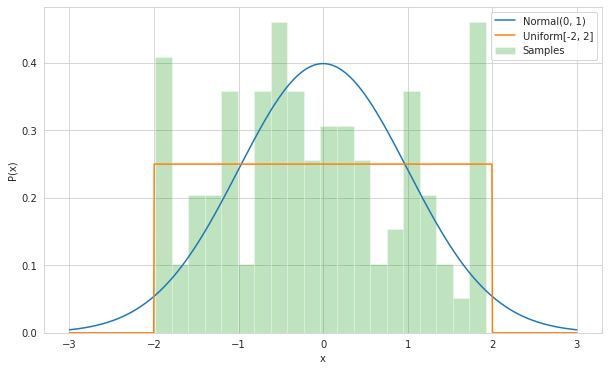

In [ ]:
n = 100
samples = stats.uniform.rvs(loc = a, scale = b, size=n)

plt.figure(figsize = (10, 6))#, dpi = 300)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x, stats.uniform.pdf(x, a, b))
plt.hist(samples, bins = 20, density = True, alpha = 0.3)
plt.xlabel("x")
plt.ylabel("P(x)")
plt.legend(['Normal(0, 1)', 'Uniform[-2, 2]', 'Samples'])
plt.show()

In [ ]:
# computing proba over time
log_probabilities = [0]
for sample in samples:
    log_proba_norm = np.log10(stats.norm.pdf(sample, mu, sigma))
    log_proba_unif = np.log10(stats.uniform.pdf(sample, a, b))
    
    last_proba = log_probabilities[-1]
    log_probabilities.append(last_proba + log_proba_unif - log_proba_norm)

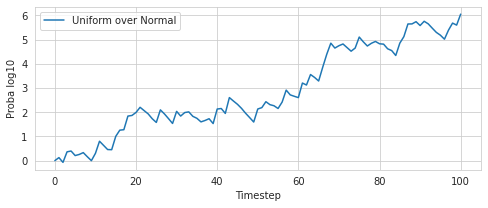

In [ ]:
plt.figure(figsize = (8, 3))#, dpi = 300)

plt.plot(np.arange(0, 101), log_probabilities)
plt.xlabel("Timestep")
plt.ylabel("Proba log10")
plt.legend(["Uniform over Normal"])
plt.show()

### Normal case

In [ ]:
n = 100
samples = stats.norm.rvs(loc = mu, scale = sigma, size=n)

In [ ]:
stats.norm(loc = mu, scale = sigma).rvs(1)

array([-1.02061301])

In [ ]:
probabilities = [1]
for idx, sample in enumerate(samples):
    if stats.uniform.pdf(sample, a, b) > 0:
        log_proba_norm = np.log10(stats.norm.pdf(sample, mu, sigma))
        log_proba_unif = np.log10(stats.uniform.pdf(sample, a, b))
    
        last_proba = np.log10(probabilities[-1])
        probabilities.append(10**(last_proba + log_proba_unif - log_proba_norm))
    else:
        probabilities += [0] * (n - idx)
        break

Generating sequence "falling" in specified index range:

In [ ]:
l_bound = -1
u_bound = 1

counter = 0
flag = True
while flag:
    samples = stats.norm.rvs(loc = mu, scale = sigma, size=n)

    probabilities = [1]
    for idx, sample in enumerate(samples):
        if stats.uniform.pdf(sample, a, b) > 0:
            log_proba_norm = np.log10(stats.norm.pdf(sample, mu, sigma))
            log_proba_unif = np.log10(stats.uniform.pdf(sample, a, b))
        
            last_proba = np.log10(probabilities[-1])
            probabilities.append(10**(last_proba + log_proba_unif - log_proba_norm))
        else:
            if idx > l_bound and idx < u_bound:
                flag = False
            probabilities += [0] * (n - idx)
            counter += 1
            break

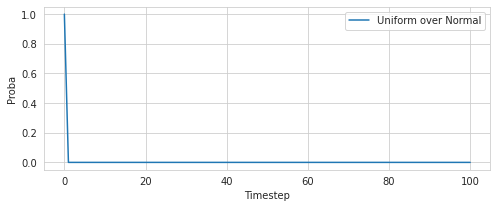

In [ ]:
plt.figure(figsize = (8, 3))#, dpi = 300)

plt.plot(np.arange(0, 101), probabilities)
plt.xlabel("Timestep")
plt.ylabel("Proba")
plt.legend(["Uniform over Normal"])
plt.show()

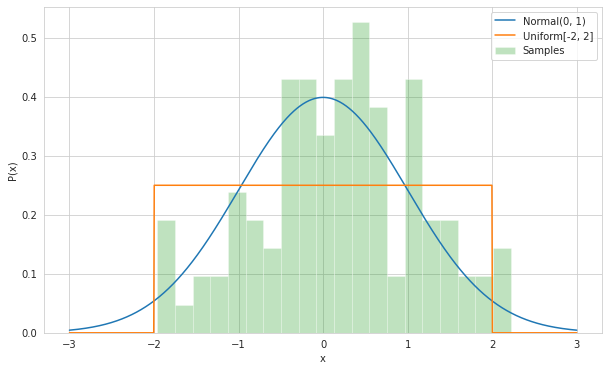

In [ ]:
plt.figure(figsize = (10, 6))#, dpi = 300)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x, stats.uniform.pdf(x, a, b))
plt.hist(samples, bins = 20, density = True, alpha = 0.3)
plt.xlabel("x")
plt.ylabel("P(x)")
plt.legend(['Normal(0, 1)', 'Uniform[-2, 2]', 'Samples'])
plt.show()

## Bayesian MAB

In [ ]:
cost = 3
distribution = stats.randint(1, 7)

bandit = UniformMultiArmedBandit(1, [cost], [distribution])

### First sample

In [ ]:
sample = bandit.trigger(0) + cost
print("Returned value:", sample)

Returned value: 3


In [ ]:
from tqdm.auto import tqdm

probabilities = np.ones((1000, 1000))

for loc in tqdm(range(1000)):
    for scale in range(1000):
        probabilities[loc, scale] *= stats.randint.pmf(sample, loc, loc + 1 + scale)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
probabilities[sample, 0]

1.0

In [ ]:
probabilities[sample - 1, 1]

0.5

In [ ]:
probabilities[sample, 1]

0.5

#### Computing expectation distribution

In [ ]:
real_probas = probabilities / probabilities.sum()

expected_mean_dict = {}

for loc in range(1000):
    for scale in range(1000):
        mean = loc + scale / 2
        # in case met first time
        current_proba = expected_mean_dict.get(mean, 0)
        expected_mean_dict[mean] = current_proba + real_probas[loc, scale]

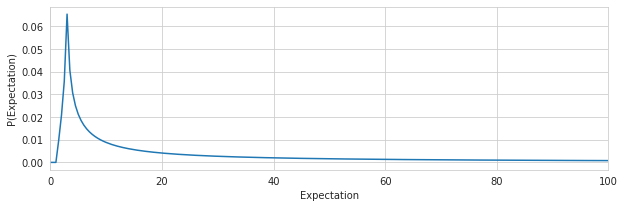

In [ ]:
mean_proba_pairs = list(expected_mean_dict.items())
mean_proba_pairs = np.array(sorted(mean_proba_pairs, key = lambda x: x[0]))

plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(mean_proba_pairs[:, 0], mean_proba_pairs[:, 1])
plt.xlim([0, 100])
plt.xlabel("Expectation")
plt.ylabel("P(Expectation)")
plt.show()

#### Computing expected expectation

In [ ]:
mean_matrix = np.zeros((1000, 1000))
for loc in range(1000):
    for scale in range(1000):
        mean_matrix[loc, scale] = loc + scale / 2

In [ ]:
mean_expectation = (real_probas * mean_matrix).sum()
print("Mean expectation = ", round(mean_expectation, 4))

Mean expectation =  79.0989


### Second sample

In [ ]:
sample2 = bandit.trigger(0) + cost
print("Returned value:", sample2)

for loc in tqdm(range(1000)):
    for scale in range(1000):
        # not wasting time on 0
        if probabilities[loc, scale]:
            probabilities[loc, scale] *= stats.randint.pmf(sample2, loc, loc + 1 + scale)

Returned value: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
max_sample = max(sample, sample2)
probabilities[max_sample:, :].sum()

0.0

In [ ]:
dist = abs(sample - sample2)
probabilities[:, :dist].sum()

0.0

In [ ]:
probabilities.astype('bool').sum()

1995

#### Computing expectation distribution

In [ ]:
real_probas = probabilities / probabilities.sum()

expected_mean_dict = {}

for loc in range(1000):
    for scale in range(1000):
        mean = loc + scale / 2
        # in case met first time
        current_proba = expected_mean_dict.get(mean, 0)
        expected_mean_dict[mean] = current_proba + real_probas[loc, scale]

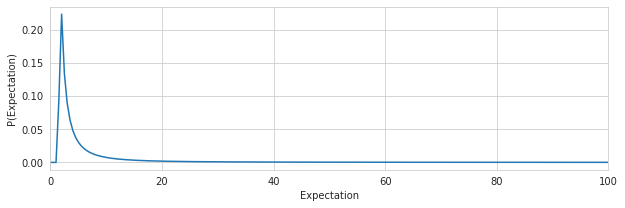

In [ ]:
mean_proba_pairs = list(expected_mean_dict.items())
mean_proba_pairs = np.array(sorted(mean_proba_pairs, key = lambda x: x[0]))

plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(mean_proba_pairs[:, 0], mean_proba_pairs[:, 1])
plt.xlim([0, 100])
plt.xlabel("Expectation")
plt.ylabel("P(Expectation)")
plt.show()

In [ ]:
mean_expectation = (real_probas * mean_matrix).sum()
print("Mean expectation = ", round(mean_expectation, 4))

Mean expectation =  8.6801


### Five samples

In [ ]:
samples = [sample, sample2]

for i in range(3):
    sample = bandit.trigger(0) + cost
    print("Returned value:", sample)

    for loc in tqdm(range(1000)):
        for scale in range(1000):
            # not wasting time on 0
            if probabilities[loc, scale]:
                probabilities[loc, scale] *= stats.randint.pmf(sample, loc, loc + 1 + scale)

    samples.append(sample)

Returned value: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Returned value: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

Returned value: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
real_probas = probabilities / probabilities.sum()

expected_mean_dict = {}

for loc in range(1000):
    for scale in range(1000):
        mean = loc + scale / 2
        # in case met first time
        current_proba = expected_mean_dict.get(mean, 0)
        expected_mean_dict[mean] = current_proba + real_probas[loc, scale]

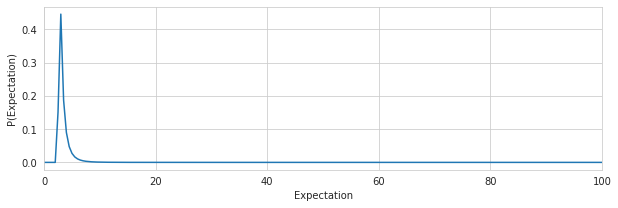

In [ ]:
mean_proba_pairs = list(expected_mean_dict.items())
mean_proba_pairs = np.array(sorted(mean_proba_pairs, key = lambda x: x[0]))

plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(mean_proba_pairs[:, 0], mean_proba_pairs[:, 1])
plt.xlim([0, 100])
plt.xlabel("Expectation")
plt.ylabel("P(Expectation)")
plt.show()

In [ ]:
mean_expectation = (real_probas * mean_matrix).sum()
print("Mean expectation = ", round(mean_expectation, 4))

Mean expectation =  3.4408


## Bayesian with prior MAB

### First sample

In [ ]:
sample = bandit.trigger(0) + cost
print("Returned value:", sample)

Returned value: 2


In [ ]:
from tqdm.auto import tqdm

prior_probabilities = np.zeros((1000, 1000))
for i in range(1000):
    prior_probabilities[i, :] = 1 / (i+1)

for loc in tqdm(range(1000)):
    for scale in range(1000):
        probabilities[loc, scale] *= stats.randint.pmf(sample, loc, loc + 1 + scale)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Computing expectation distribution

In [ ]:
real_probas = probabilities / probabilities.sum()

expected_mean_dict = {}

for loc in range(1000):
    for scale in range(1000):
        mean = loc + scale / 2
        # in case met first time
        current_proba = expected_mean_dict.get(mean, 0)
        expected_mean_dict[mean] = current_proba + real_probas[loc, scale]

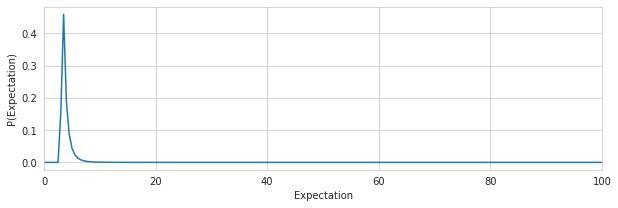

In [ ]:
mean_proba_pairs = list(expected_mean_dict.items())
mean_proba_pairs = np.array(sorted(mean_proba_pairs, key = lambda x: x[0]))

plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(mean_proba_pairs[:, 0], mean_proba_pairs[:, 1])
plt.xlim([0, 100])
plt.xlabel("Expectation")
plt.ylabel("P(Expectation)")
plt.show()

#### Computing expected expectation

In [ ]:
mean_matrix = np.zeros((1000, 1000))
for loc in range(1000):
    for scale in range(1000):
        mean_matrix[loc, scale] = loc + scale / 2

In [ ]:
mean_expectation = (real_probas * mean_matrix).sum()
print("Mean expectation = ", round(mean_expectation, 4))

Mean expectation =  3.8668


### Five samples

In [ ]:
samples = [sample]

for i in range(4):
    sample = bandit.trigger(0) + cost
    print("Returned value:", sample)

    for loc in tqdm(range(1000)):
        for scale in range(1000):
            # not wasting time on 0
            if probabilities[loc, scale]:
                probabilities[loc, scale] *= stats.randint.pmf(sample, loc, loc + 1 + scale)

    samples.append(sample)

Returned value: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Returned value: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Returned value: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Returned value: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
real_probas = probabilities / probabilities.sum()

expected_mean_dict = {}

for loc in range(1000):
    for scale in range(1000):
        mean = loc + scale / 2
        # in case met first time
        current_proba = expected_mean_dict.get(mean, 0)
        expected_mean_dict[mean] = current_proba + real_probas[loc, scale]

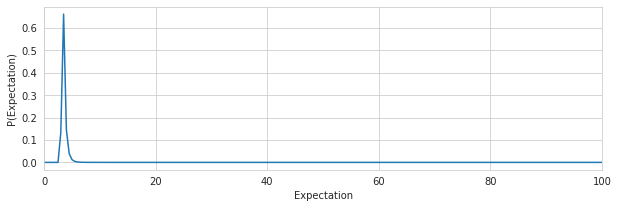

In [ ]:
mean_proba_pairs = list(expected_mean_dict.items())
mean_proba_pairs = np.array(sorted(mean_proba_pairs, key = lambda x: x[0]))

plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(mean_proba_pairs[:, 0], mean_proba_pairs[:, 1])
plt.xlim([0, 100])
plt.xlabel("Expectation")
plt.ylabel("P(Expectation)")
plt.show()

In [ ]:
mean_expectation = (real_probas * mean_matrix).sum()
print("Mean expectation = ", round(mean_expectation, 4))

Mean expectation =  3.5812


## Task (Optional)

Create the best possible prior for existing initialization of distributions (when `distributions` is `None`). Explain why ypou suppose that prior you found is the best given initialisation schema. 

Generate 10 one-handed bandits and for each of them perform 100 steps of mean approximation using 3 priors:
1. The best one
2. Inverse loc 
3. Uniform prior

Plot an approximation error for the expectation (MAE) at each of 100 steps for all the 3 priors. Draw a single plot, aggregating errors at steps (by mean) from all 10 bandits. 

## Bayesian Upper Confidence Bound

In [ ]:
from tqdm import tqdm

In [ ]:
bandit = UniformMultiArmedBandit(4, costs = [0] * 4)
n_arms = 4

In [ ]:
prior_probabilities = np.zeros((4, 1000, 1000))
for i in range(1000):
    prior_probabilities[:, i, :] = 1 / (i+1)

In [ ]:
rewards = [[bandit.trigger(i)] for i in range(n_arms)]

In [ ]:
for i in range(4):
    for loc in tqdm(range(1000)):
        for scale in range(1000):
            prior_probabilities[i, loc, scale] *= stats.randint.pmf(rewards[i], loc, loc + 1 + scale)

100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]


In [ ]:
# mean matrix is common
mean_matrix = np.zeros((1000, 1000))
for loc in range(1000):
    for scale in range(1000):
        mean_matrix[loc, scale] = loc + scale / 2


def bayesian_policy(probas, n_arms = 4, c = 1):
    upper_bounds = []
    mean_expectations = []
    # computing mean expectation and std
    for i in range(n_arms):
        # computing proba for each mean
        real_probas = probas[i] / probas[i].sum()

        # mean expectation
        mean_expectation = (real_probas * mean_matrix).sum()
        # expectation of square - square of expectation
        variance = mean_matrix**2 * real_probas - mean_expectation**2
        std = variance ** 0.5

        mean_expectations.append(mean_expectation)
        upper_bounds.append(mean_expectation + c * std)

    return np.argmax(upper_bounds), mean_expectations[np.argmax(upper_bounds)]

def update_prediction(probas, arm_id, sample):
    for loc in range(1000):
        for scale in range(1000):
            # not wasting time on 0
            if probas[arm_id, loc, scale]:
                probas[arm_id, loc, scale] *= stats.randint.pmf(sample, loc, loc + 1 + scale)

In [ ]:
# mean reward for each arm
actual_means = [arm.distribution.mean() - arm.cost for arm in bandit.arms]
# max mean reward
real_max_exp = max(actual_means)

estimated_mean_policy = []
real_mean_policy = []

N = 100

for i in tqdm(range(N)):
    # choosing an action
    action, expectation = bayesian_policy(prior_probabilities, 4, 10)
    reward = bandit.trigger(action)
    # updating prediction
    update_prediction(prior_probabilities, action, reward)

    # recording the results
    estimated_mean_policy.append(expectation)
    rewards[action].append(reward)
    real_mean_policy.append(actual_means[action])

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


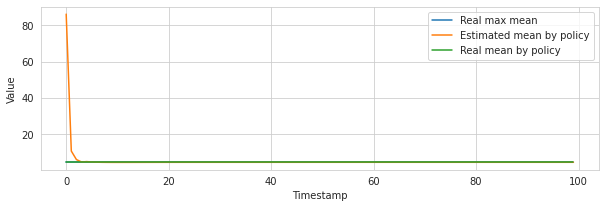

In [ ]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(N), [real_max_exp] * N, )
plt.plot(np.arange(N), estimated_mean_policy)
plt.plot(np.arange(N), real_mean_policy)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()

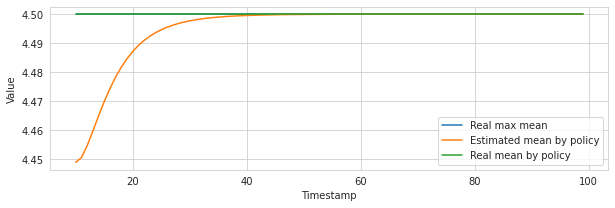

In [ ]:
plt.figure(figsize = (10, 3))#, dpi = 300)
plt.plot(np.arange(10, N), [real_max_exp] * (N - 10))
plt.plot(np.arange(10, N), estimated_mean_policy[10:])
plt.plot(np.arange(10, N), real_mean_policy[10:])
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend(['Real max mean', 'Estimated mean by policy', 'Real mean by policy'])
plt.show()